# Generating lognormal and Gaussian fields correlated with input ACT CMB lensing maps.

In this notebook we show how to generate a field using the fieldgen package.

We will focus just on the galaxy density field.

The generated density field will be correlated with the ACT CMB lensing fields. So no need for any noise treatment.

The signal part of the field can be:

* lognormal
* Gaussian

For any questions or bugs o.darwish@proton.me

In [1]:
# Here we import useful packages that will be used throught the notebook

import healpy as hp

from plancklens.utils import alm_copy
from plancklens import shts

import numpy as np

import pathlib

%reload_ext autoreload
%autoreload 2

from fieldgen import lognormal, conditionedsims as cs, utils as fgutils, logutils

import matplotlib.pyplot as plt
#retina display
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['font.size'] = 12


Using lenspyx alm2map


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### First of all, let's setup some general things

In [2]:
Nfields = 3
lambdas = np.array([3, 1.089, 1.106])

seed = 144

#maps
nside = 1024

lmax = 6000

fixed_index = 2 #fixed index for the CMB lensing convergence field

## Let's get an input lensing map

In [3]:
nside_gen = 2048

direc_phi = pathlib.Path("/Users/omard/Downloads/toJohnny/")
name_phi = f"fullskyPhi_alm_{seed:05}.fits"

#for some reaons pxlensing giving weird results, so do by hand
philm = hp.read_alm(direc_phi/name_phi).astype(np.complex128)
lmax = hp.Alm.getlmax(philm.size)
lphi = np.arange(lmax + 1)
factor = lphi*(lphi + 1)/(2)
klm = hp.almxfl(philm, factor)
kappa = shts.alm2map(klm.copy(), nside = nside_gen)

In [4]:
mean_kappa = logutils.get_mean_from_map(kappa) #note mean calc at nside_gen

### Now, let's get some spectra

In [5]:
def prepare_get_functions_for_conditioned_sims(theoryinputdir, lmax = 3072):

    clkk = np.loadtxt(pathlib.Path(theoryinputdir/"clkk_input.dat"))[:lmax]

    get_kk = lambda: clkk[:lmax]

    get_kg = lambda b: np.loadtxt(theoryinputdir/f'kg{b}.txt')[:lmax]

    def get_gg(a, b):
        try:
            return np.loadtxt(theoryinputdir/f'g{a}g{b}.txt')[:lmax]
        except:
            return np.loadtxt(theoryinputdir/f'g{b}g{a}.txt')[:lmax]
    
    return get_kk, get_kg, get_gg


def get_get_AB(theoryinputdir, fixed_index = 0, lmax = 6000, nside = 1024, apply_pixwin = True):


    #lmax = min(lmax, 3*nside)

    get_kk, get_kg, get_gg = prepare_get_functions_for_conditioned_sims(theoryinputdir, lmax)

    pixwin = hp.pixwin(nside)[:lmax] if apply_pixwin else 1.0

    def get_AB(a, b):
        if (a == fixed_index) or (b == fixed_index):
            if a == b:
                return get_kk()
            elif a == fixed_index:
                return get_kg(b)*pixwin
            else:
                return get_kg(a)*pixwin
        else:
            return get_gg(a, b)*pixwin**2
    return get_AB

In [6]:
spectra_dir = pathlib.Path("/Users/omard/Downloads/toJohnny/spectra_simple/")
get_AB = get_get_AB(spectra_dir, fixed_index = fixed_index, lmax = lmax, nside = nside, apply_pixwin = False)
#create a 3D matrix from get_AB
cls = np.zeros((Nfields, Nfields, lmax))

for i in range(Nfields-1):
    for j in range(Nfields-1):
        cls[i+1, j+1] = get_AB(i, j)
    cls[0, i+1] = get_AB(fixed_index, i)
    cls[i+1, 0] = cls[0, i+1]
cls[0, 0] = get_AB(fixed_index, fixed_index)

del get_AB

In [7]:
Getter = fgutils.SpectraGetter(cls, fixed_index)

## Now we are ready to generate fields

In [8]:
LC = lognormal.LognormalConditionedSims(Nfields-1, Getter, realized_field_index = fixed_index, lambdas = lambdas, means_of_fields = np.repeat(mean_kappa, Nfields))

In [9]:
alms, maps = LC.generate_alm(seed, kappa, nside, out_real = True, process = True)

In [10]:
out_lambdas_other = [logutils.get_lambda_from_mappa(m) for m in maps]
print(out_lambdas_other/lambdas[1:]-1)

[0.0349502  0.04131688]


## Can also generate Gaussians

In [11]:
G = cs.ConditionedSims(Nfields-1, Getter, realized_field_index = fixed_index)
Galms = G.generate_alm(seed, klm)

In [12]:
Gmaps = [shts.alm2map(G.copy(), nside = nside) for G in Galms]

In [13]:
Gout_lambdas_other = [logutils.get_lambda_from_mappa(m) for m in Gmaps]
print(Gout_lambdas_other/lambdas[1:]-1)

[10998.3728348  10387.10777316]


## Let's get a reconstructed kappa

In [14]:
path = direc_phi#pathlib.Path("")
kappa_alm = hp.read_alm(path/f"all_MV_simlensing_mf-sub_mc-corr_MV_{seed}.fits")

lensing_mask = hp.read_map(path/"act_GAL040_mask_healpy_nside=2048.fits")
#mean preserved for nside
w2 = np.mean(lensing_mask**2)

kappa_alm /= w2

#just a simple w factor correction here for illustrative purposes

In [15]:
lmaxkappa = hp.Alm.getlmax(klm.size)
mapsout_lm= [alm_copy(m, min(lmax, 3*nside-1)) for m in alms]

Gmapsout_lm = [alm_copy(m, min(lmax, 3*nside-1)) for m in Galms]

kappa_map = kappa_alm
klm_lm_copy = alm_copy(kappa_map, min(lmax, 3*nside-1))

cls_out_gg_cross = [hp.alm2cl(mapsout_lm[i], mapsout_lm[j]) for i in range(Nfields-1) for j in range(i, Nfields-1)]
cls_out_cross = [hp.alm2cl(mlm, klm_lm_copy) for mlm in mapsout_lm]

Gcls_out_gg_cross = [hp.alm2cl(Gmapsout_lm[i], Gmapsout_lm[j]) for i in range(Nfields-1) for j in range(i, Nfields-1)]
Gcls_out_cross = [hp.alm2cl(mlm, klm_lm_copy) for mlm in Gmapsout_lm]

kappa_map = klm
klm_lm_copy = alm_copy(kappa_map, min(lmax, 3*nside-1))
cls_out_cross_input = [hp.alm2cl(mlm, klm_lm_copy) for mlm in mapsout_lm]
Gcls_out_cross_input = [hp.alm2cl(mlm, klm_lm_copy) for mlm in Gmapsout_lm]

#Gcls_cls_cross = [hp.alm2cl(mG, m) for mG, m in zip(Gmapsout_lm, mapsout_lm)]

/Users/omard/Documents/projects/fieldgen/fieldgen/utils.py:65: RuntimeWarning: invalid value encountered in divide
  cl = cl[0] / sums[0]


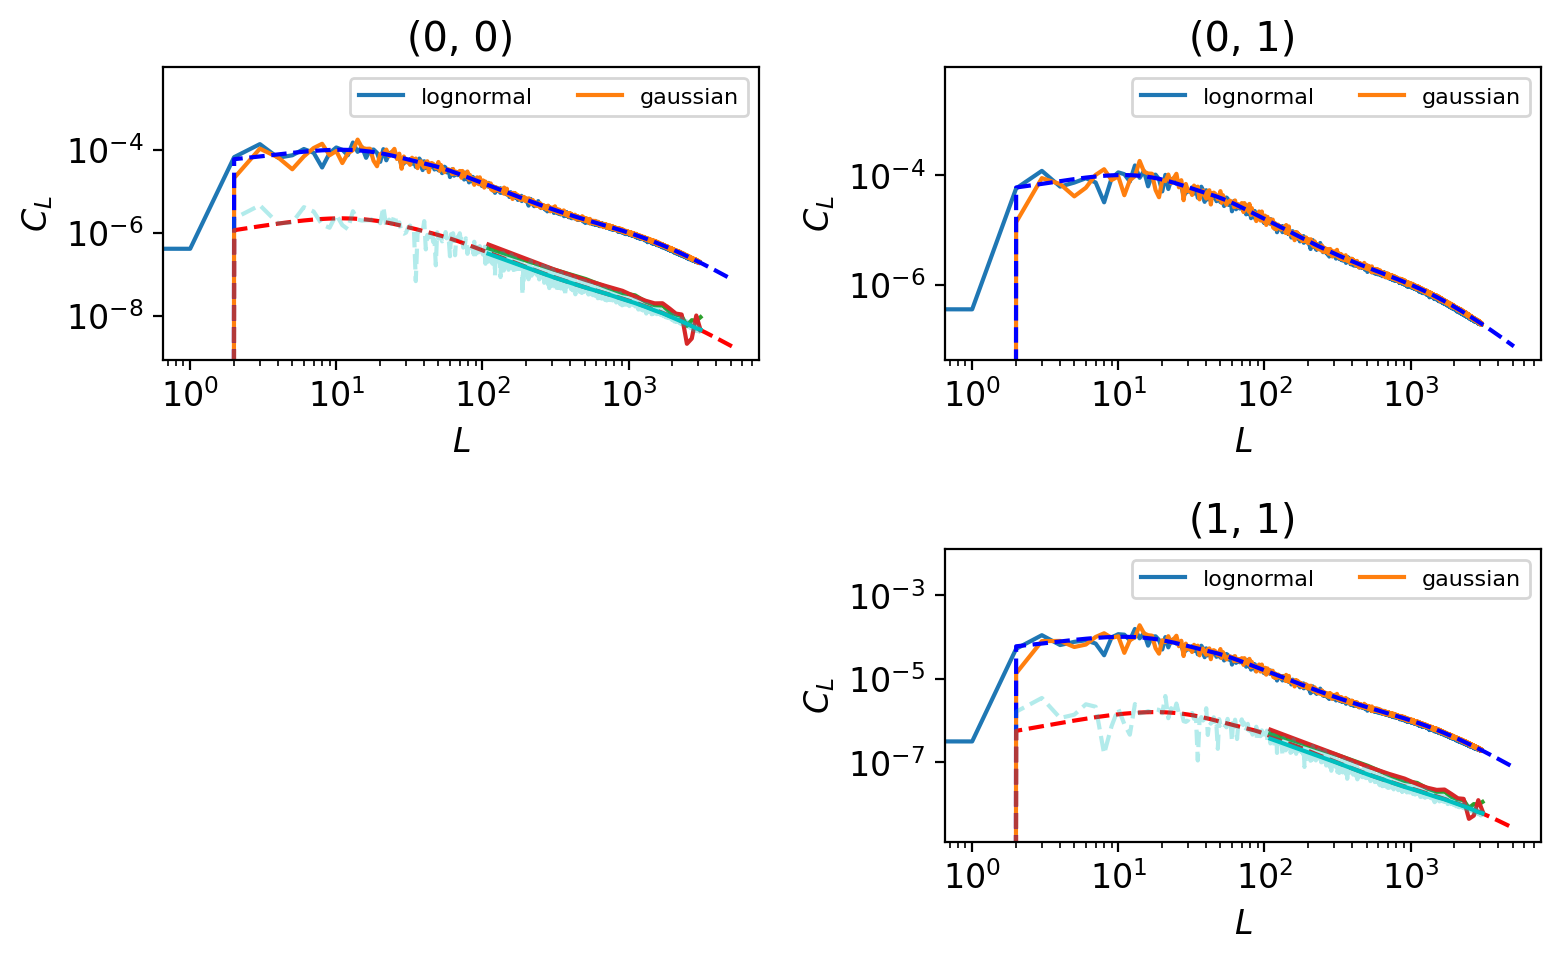

In [16]:
fig, ax = plt.subplots(Nfields-1, Nfields-1, figsize = (8, 5))
for i, j in np.ndindex(Nfields-1, Nfields-1):
    if i > j:
        ax[i, j].axis("off")
    else:

        #get index for cls
        index = i*(Nfields-1)+j-i*(i+1)//2

        ax[i, j].loglog(cls_out_gg_cross[index], label = "lognormal")
        ax[i, j].plot(Gcls_out_gg_cross[index], label = "gaussian")
        
        theory = LC.get_AB(i, j)
        ax[i, j].plot(theory, color = "b", ls = "--")

        if i == j:
            theory = LC.get_AB(i, fixed_index)
            ax[i, j].plot(theory, color = "r", ls = "--")

            lista = [cls_out_cross[i], Gcls_out_cross[i]]
            for l in lista:
                cents, d = fgutils.simple_binning(l)

                ax[i, j].plot(cents, d)
            
            cents, d = fgutils.simple_binning(cls_out_cross_input[i])
            ax[i, j].plot(cents, d, color = "c")
            ax[i, j].plot(cls_out_cross_input[i], color = "c", ls = "--", alpha = 0.3)


        ax[i, j].set_title(f"({i}, {j})")

        ax[i, j].set_xlabel(r"$L$")
        ax[i, j].set_ylabel(r"$C_L$")
        ax[i, j].legend(ncol = 2, fontsize = 8)
    
plt.tight_layout()

### Let's just check the noiseless input for simple binning

Not perfect, but can be improved.

Text(0, 0.5, '$C_L$')

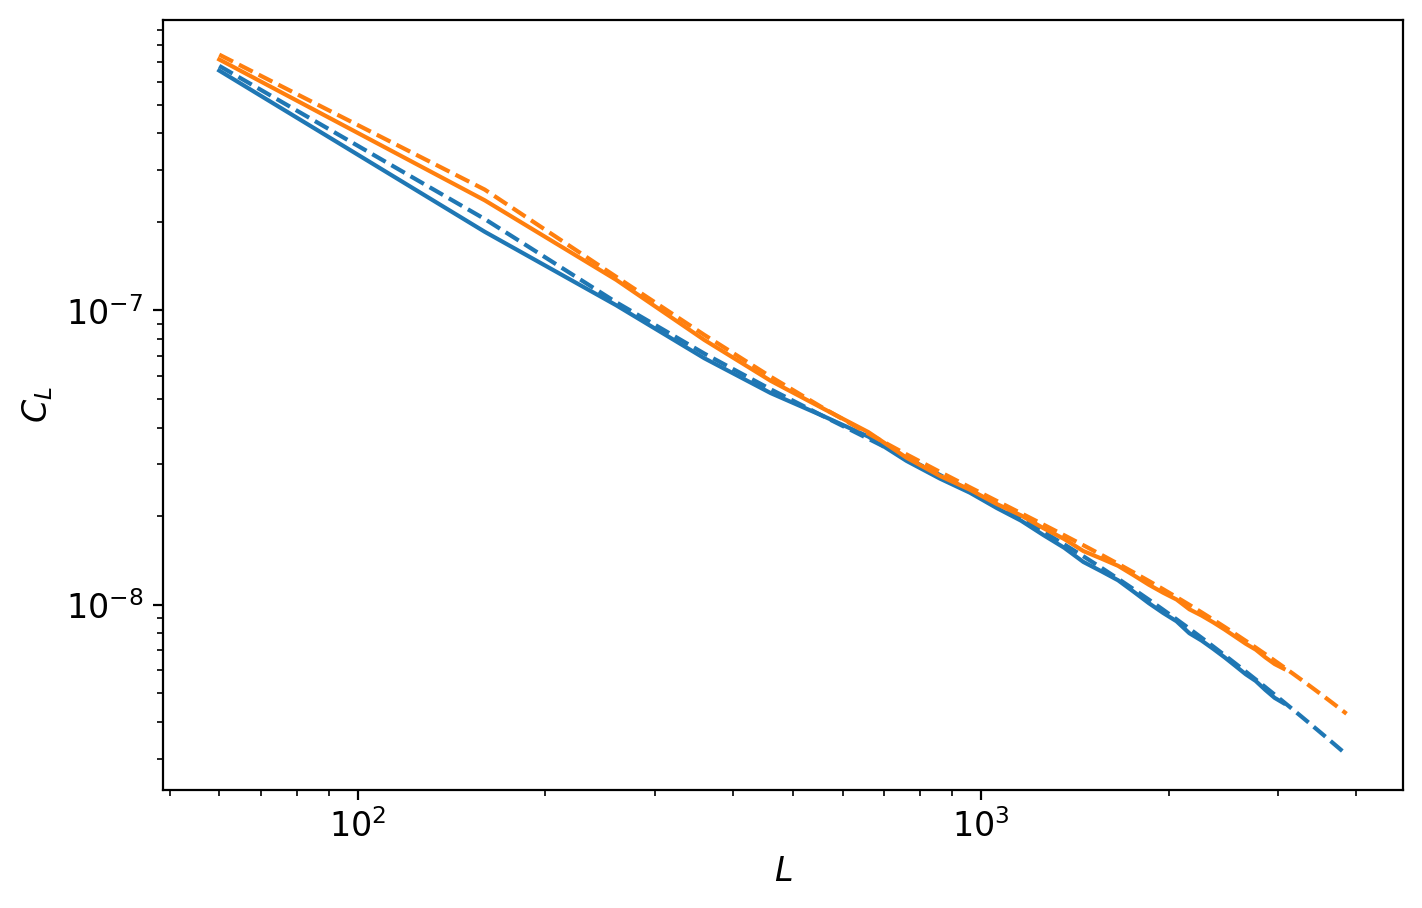

In [17]:
binning = np.arange(10, 4000, 100)
for i in range(Nfields-1):
    theory = LC.get_AB(i, fixed_index)
    cents, d = fgutils.simple_binning(theory, binning)
    p = plt.plot(cents, d, ls = "--")
    cents, d = fgutils.simple_binning(cls_out_cross_input[i], binning)
    plt.loglog(cents, d, color = p[0].get_color())



plt.xlabel(r"$L$")
plt.ylabel(r"$C_L$")


## Populate

Now we generate Poisson sampled simulations.

For a Gaussian field use $\alpha < 1$. For lognormal, just unity.

In [23]:
from fieldgen import catutils

weights = np.ones(Nfields-1)

Nobs = [150000, 222000]

mask = np.ones_like(maps[0])

alpha = 0.9

counts = [catutils.delta_g_to_number_counts(delta_g_input_real = deltag, No_observed = No, seed = seed, mask = mask, weights = 1, alpha = alpha) for deltag, No in zip(maps, Nobs)]

columns = catutils.get_catalog(seed = seed, Npix = len(mask), nside = nside, number_counts = counts, z = 0, nz = 0, sample_z = False)

#columnsnames = ['RA', 'DEC', 'Z', 'ZBIN', 'WEIGHT']
#catutils.save_catalog(filename = self.directory/f'{filename}.fits', columnsnames = columnsnames, columns = columns)

In [24]:
counts_means = [np.mean(counts_) for counts_ in counts]
delta_contrast_counts = [(counts_ - counts_mean)/counts_mean for counts_, counts_mean in zip(counts, counts_means)]
delta_alm = [shts.map2alm(delta_contrast_counts_.copy(), lmax = lmax) for delta_contrast_counts_ in delta_contrast_counts]

In [27]:
lmaxkappa = hp.Alm.getlmax(klm.size)
mapsout_lm = [alm_copy(m, min(lmax, 3*nside-1)) for m in delta_alm]

kappa_map = kappa_alm
klm_lm_copy = alm_copy(kappa_map, min(lmax, 3*nside-1))

cls_out_gg_cross = [hp.alm2cl(mapsout_lm[i], mapsout_lm[j])/alpha**2. for i in range(Nfields-1) for j in range(i, Nfields-1)]
cls_out_cross = [hp.alm2cl(mlm, klm_lm_copy)/alpha for mlm in mapsout_lm]

kappa_map = klm
klm_lm_copy = alm_copy(kappa_map, min(lmax, 3*nside-1))
cls_out_cross_input = [hp.alm2cl(mlm, klm_lm_copy)/alpha for mlm in mapsout_lm]

#Gcls_cls_cross = [hp.alm2cl(mG, m) for mG, m in zip(Gmapsout_lm, mapsout_lm)]

/Users/omard/Documents/projects/fieldgen/fieldgen/utils.py:65: RuntimeWarning: invalid value encountered in divide
  cl = cl[0] / sums[0]


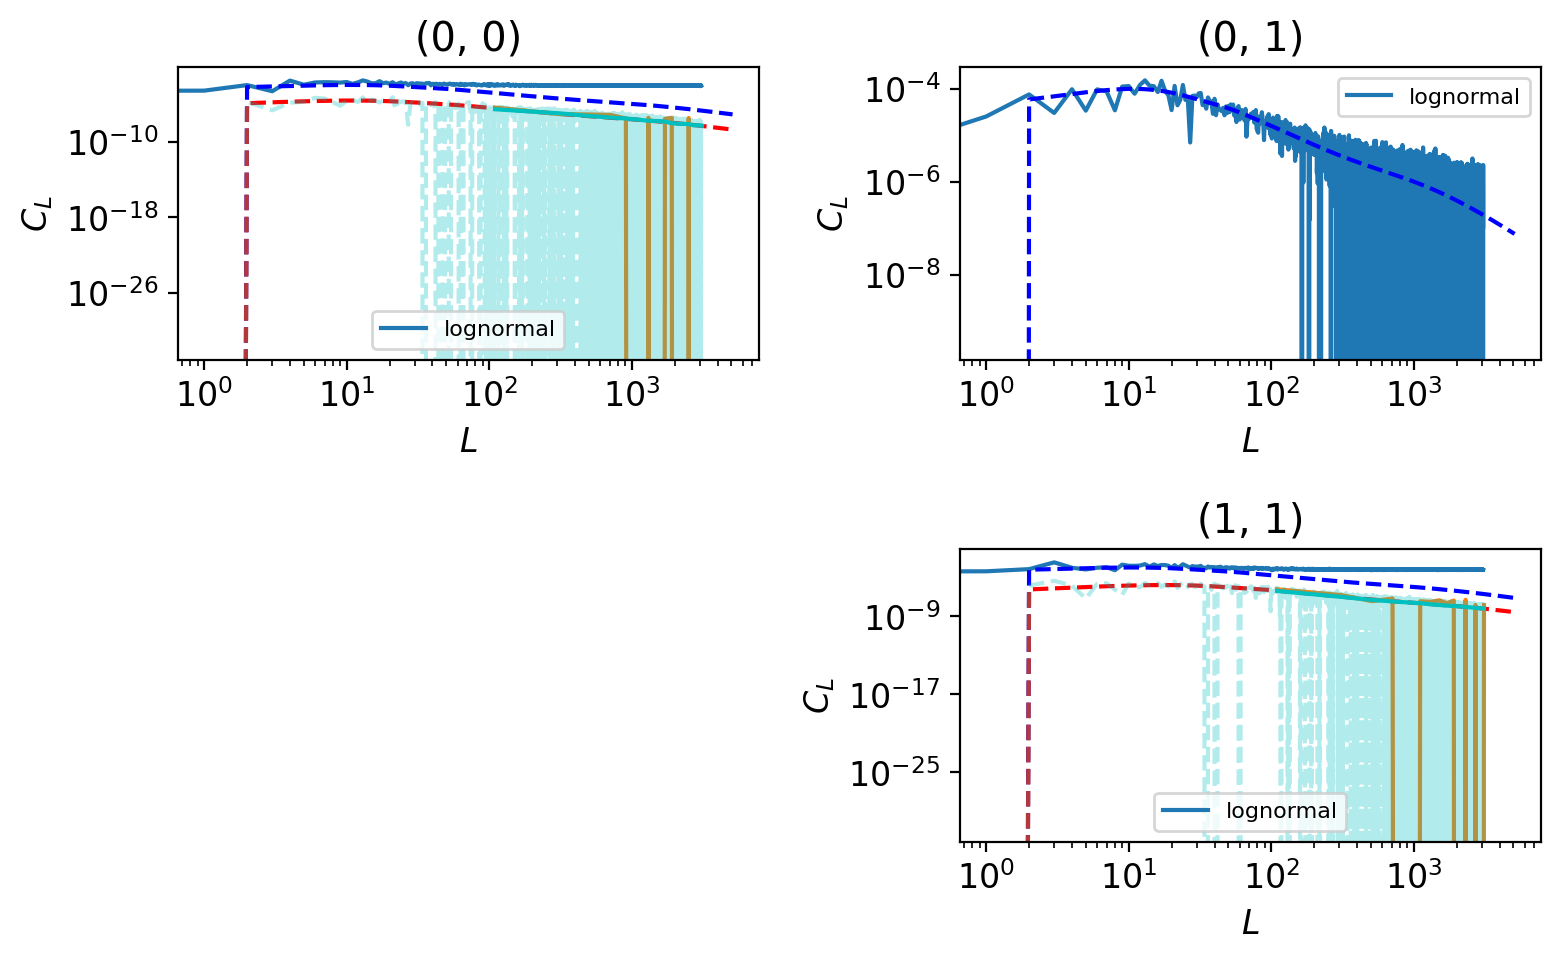

In [28]:
fig, ax = plt.subplots(Nfields-1, Nfields-1, figsize = (8, 5))
for i, j in np.ndindex(Nfields-1, Nfields-1):
    if i > j:
        ax[i, j].axis("off")
    else:

        #get index for cls
        index = i*(Nfields-1)+j-i*(i+1)//2

        ax[i, j].loglog(cls_out_gg_cross[index], label = "lognormal")
        
        theory = LC.get_AB(i, j)
        ax[i, j].plot(theory, color = "b", ls = "--")

        if i == j:
            theory = LC.get_AB(i, fixed_index)
            ax[i, j].plot(theory, color = "r", ls = "--")

            lista = [cls_out_cross[i]] #, Gcls_out_cross[i]]
            for l in lista:
                cents, d = fgutils.simple_binning(l)

                ax[i, j].plot(cents, d)
            
            cents, d = fgutils.simple_binning(cls_out_cross_input[i])
            ax[i, j].plot(cents, d, color = "c")
            ax[i, j].plot(cls_out_cross_input[i], color = "c", ls = "--", alpha = 0.3)


        ax[i, j].set_title(f"({i}, {j})")

        ax[i, j].set_xlabel(r"$L$")
        ax[i, j].set_ylabel(r"$C_L$")
        ax[i, j].legend(ncol = 2, fontsize = 8)
    
plt.tight_layout()